<a href="https://colab.research.google.com/github/prateeknigam9/Meme-classifier/blob/main/Image_Based_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image based learning


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Colab Notebooks/Case_study2/data'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/Case_study2/data


In [ ]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
import cv2
from tqdm import tqdm
from keras.preprocessing import image
import keras
import tensorflow as tf
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten,Conv2D, MaxPooling2D,Input,MaxPool2D
from keras import Model
%load_ext tensorboard
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score,roc_curve,classification_report

In [ ]:
data = pd.read_csv('data.csv')
data.head(3)

,title,author,id,ups,downs,thumbnail.height,thumbnail.width,date_created,Dank_or_not,meme_path,clean_sent,sentiment,word_count,year,month,day,hour
0,Num🅱er One,DrarenThiralas,6tehbc,87082,0,121,140,2017-08-13 10:45:09,1,memes/6tehbc.jpg,rleurope h ruvis u batteries included life is...,0.0,22,2017,8,13,10
1,Got ‘em,CasualDad8675309,8bse8k,75251,0,98,140,2018-04-12 18:21:27,1,memes/8bse8k.jpg,when reddit is making fun of mark zuckerberg f...,0.0,14,2018,4,12,18
2,50-0,NikiTosThePleb,6we7gp,64236,0,140,140,2017-08-27 19:30:27,1,memes/6we7gp.jpg,how to make millions damn wish l could read fi...,0.0,14,2017,8,27,19


In [ ]:
data = data[['meme_path','Dank_or_not']]
data.head()

,meme_path,Dank_or_not
0,memes/6tehbc.jpg,1
1,memes/8bse8k.jpg,1
2,memes/6we7gp.jpg,1
3,memes/7qbcqw.jpg,1
4,memes/7szw80.jpg,1


In [ ]:
X = data['meme_path']
y = data['Dank_or_not']

POSITIVE RANKED MEMES


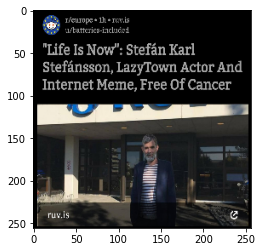

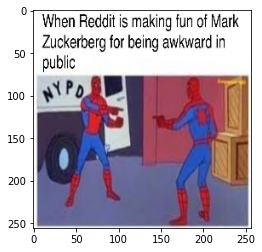

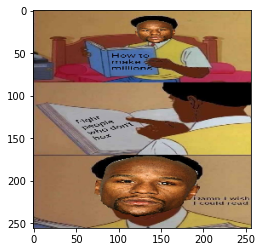

In [ ]:
print("POSITIVE RANKED MEMES")
for img in data[data['Dank_or_not'] == 1]['meme_path'][:3]:
  im = cv2.imread(img)
  im_resized = cv2.resize(im,(256,256),interpolation=cv2.INTER_LINEAR)
  plt.imshow(cv2.cvtColor(im_resized,cv2.COLOR_BGR2RGB))
  plt.show()

NEGATIVE RANKED MEMES


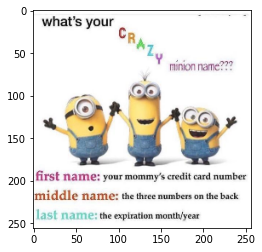

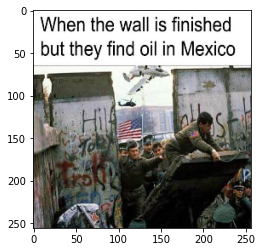

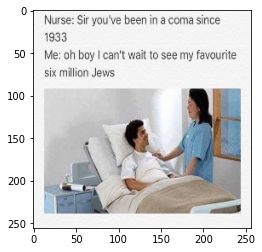

In [ ]:
print("NEGATIVE RANKED MEMES")
for img in data[data['Dank_or_not'] == 0]['meme_path'][:3]:
  im = cv2.imread(img)
  im_resized = cv2.resize(im,(256,256),interpolation=cv2.INTER_LINEAR)
  plt.imshow(cv2.cvtColor(im_resized,cv2.COLOR_BGR2RGB))
  plt.show()

## Image Preprocessing

In [ ]:
image_ = []
action=[]
exceptions=[]
for img_path,target in tqdm(zip(X,y)):
  try:
    img = image.load_img(img_path, target_size=(256,256,3), grayscale=False)
    img = image.img_to_array(img)
    img = img/255
    image_.append(img)
    action.append(target)
  except:
    exceptions.append(img_path)
X = np.array(image_)
y = np.array(action)

3218it [00:44, 71.67it/s]


## Splitting the Data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, random_state=42, test_size=0.2)

In [ ]:
print("train_shape:",X_train.shape)
print("cv_shape:",X_cv.shape)
print("test_shape:",X_test.shape)

train_shape: (2059, 256, 256, 3)
cv_shape: (515, 256, 256, 3)
test_shape: (644, 256, 256, 3)


In [ ]:
def threshold_func(true,pred):
  FPR,TPR,th = roc_curve(true,pred)
  return th
def threshold(true,pred):
    return tf.py_function(threshold_func,(true,pred),tf.double)

In [ ]:
def predict(test,model,th):
    pred = model.predict(test)
    predicted=[]
    for i in pred:
       if i > th:
          predicted.append(1)
       else:
          predicted.append(0)

    return predicted

In [ ]:
def metrics(true,pred):
    result={}
    cf = confusion_matrix(true,pred)
    sns.heatmap(cf)
    plt.show()

    acc = accuracy_score(true,pred)
    print("#####################")
    print("accuracy:",acc)
    print("#####################")

    auc_score = roc_auc_score(true,pred)
    print("#####################")
    print("auc_score:",auc_score)
    print("#####################")
    
    CR = classification_report(true,pred)
    print("#####################")
    print("classsifciation Report",CR)
    print("#####################")

    result['accuracy'] = acc
    result['roc_auc_score'] = auc_score
    result['classification_report'] = CR

    return result

## Simple Convolutional Network

**with Maxpooling**

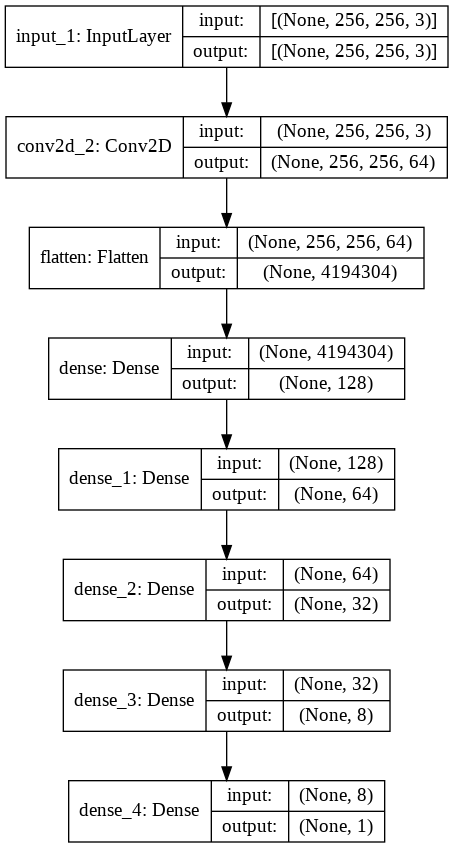

In [ ]:
tf.keras.backend.clear_session()
Input_layer = Input(shape=(256,256,3))
layer = Conv2D(16, 3, padding='same', activation='relu')(Input_layer)
# layer = MaxPooling2D()(layer)
layer = Conv2D(32, 3, padding='same', activation='relu')(Input_layer)
# layer = MaxPooling2D()(layer)
layer = Conv2D(64, 3, padding='same', activation='relu')(Input_layer)
# layer = MaxPooling2D()(layer)
layer = Flatten()(layer)
layer = Dense(128, activation='relu')(layer)
layer = Dense(64, activation='relu')(layer)
layer = Dense(32, activation='relu')(layer)
layer = Dense(8, activation='relu')(layer)
output_layer = Dense(1, activation='sigmoid')(layer)

model = Model(Input_layer,output_layer)
tf.keras.utils.plot_model(model,show_shapes=True)

In [ ]:
model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy',tf.keras.metrics.AUC(),threshold])

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    # tf.keras.callbacks.ModelCheckpoint(filepath='/content/model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='/content/logs'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=5,min_lr=0.001)
]
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_cv, y_cv), steps_per_epoch=100, verbose=2,callbacks=[callbacks])

In [ ]:
%tensorboard --logdir /content/logs

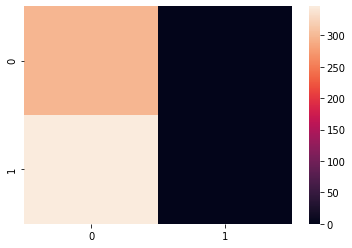

#####################
accuracy: 0.46273291925465837
#####################
#####################
auc_score: 0.5
#####################
#####################
classsifciation Report               precision    recall  f1-score   support

           0       0.46      1.00      0.63       298
           1       0.00      0.00      0.00       346

    accuracy                           0.46       644
   macro avg       0.23      0.50      0.32       644
weighted avg       0.21      0.46      0.29       644

#####################


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
pred = predict(X_test,model,th = 0.985)
result = metrics(y_test,pred)

## Trasfer learning with VGG16
**VGG16**

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
vgg16_model = tf.keras.applications.VGG16(weights='imagenet',include_top=False,input_shape=(256,256,3))
for layer in vgg16_model.layers:
  layer.trainable=False

58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
kernel_size_ = int(256/(2**5))
print(kernel_size_)

8


In [ ]:
tf.keras.backend.clear_session()
model = Sequential()

model.add(vgg16_model)

#Conv Layer
model.add(Conv2D(filters=1024,kernel_size=kernel_size_,padding='same',data_format='channels_last',
              activation='relu',name='Conv1',kernel_regularizer=tf.keras.regularizers.l2(0.001)))
#Conv Layer
model.add(Conv2D(filters=1024,kernel_size=kernel_size_,padding='same',data_format='channels_last',
              activation='relu',name='Conv2'))

#maxpool layer
# model.add(MaxPool2D(pool_size = (2,2), strides = (2,2), padding = 'same', data_format= 'channels_last'))

#flatten layer
model.add(Flatten(data_format = 'channels_last'))

#output layer
model.add(Dense(units = 16, activation = 'relu', kernel_initializer=tf.keras.initializers.he_normal(seed=3)))
model.add(Dense(units = 8, activation = 'relu', kernel_initializer=tf.keras.initializers.he_normal(seed=3)))
model.add(Dense(units = 1, activation = 'sigmoid', kernel_initializer=tf.keras.initializers.he_normal(seed=3)))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
Conv1 (Conv2D)               (None, 8, 8, 1024)        33555456  
_________________________________________________________________
Conv2 (Conv2D)               (None, 8, 8, 1024)        67109888  
_________________________________________________________________
flatten (Flatten)            (None, 65536)             0         
_________________________________________________________________
dense (Dense)                (None, 16)                1048592   
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9

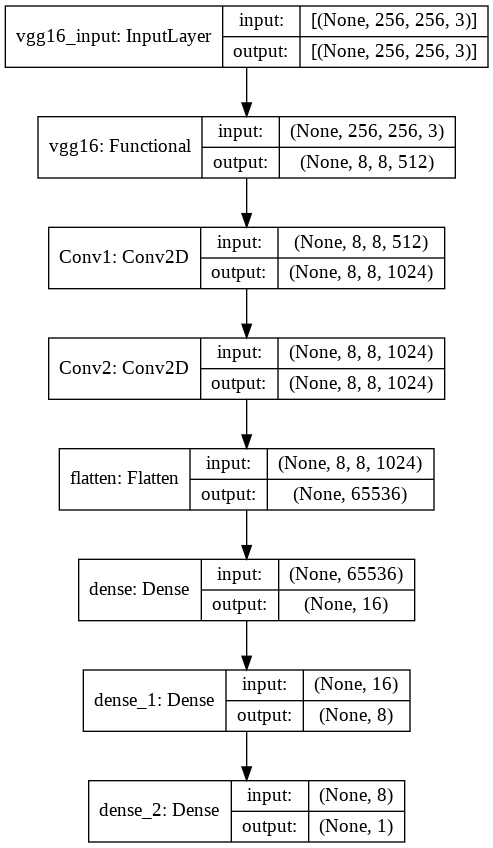

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.01),loss='binary_crossentropy',metrics=['accuracy',tf.keras.metrics.AUC(),threshold])
tf.keras.utils.plot_model(model,show_shapes=True)

In [ ]:
!rm -rf '/content/logs'

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    # tf.keras.callbacks.ModelCheckpoint(filepath='/content/model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='/content/logs'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=5,min_lr=0.001)
]
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_cv, y_cv), steps_per_epoch=100, verbose=2,callbacks=[callbacks])

In [ ]:
%tensorboard --logdir /content/logs

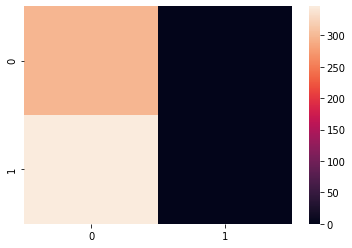

#####################
accuracy: 0.46273291925465837
#####################
#####################
auc_score: 0.5
#####################
#####################
classsifciation Report               precision    recall  f1-score   support

           0       0.46      1.00      0.63       298
           1       0.00      0.00      0.00       346

    accuracy                           0.46       644
   macro avg       0.23      0.50      0.32       644
weighted avg       0.21      0.46      0.29       644

#####################


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
pred = predict(X_test,model,th = 0.986)
result = metrics(y_test,pred)

## Transfer learning Inception V3

**Inception V3**

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
inception_model = InceptionV3(input_shape = (256, 256, 3), include_top = False, weights = 'imagenet')

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
for layer in inception_model.layers:
    layer.trainable = False

In [ ]:
tf.keras.backend.clear_session()
model = Sequential()

model.add(inception_model)

#Conv Layer
model.add(Conv2D(filters=1024,kernel_size=kernel_size_,padding='same',data_format='channels_last',
              activation='relu',name='Conv1',kernel_regularizer=tf.keras.regularizers.l2(0.001)))
#Conv Layer
model.add(Conv2D(filters=1024,kernel_size=kernel_size_,padding='same',data_format='channels_last',
              activation='relu',name='Conv2'))

#maxpool layer
model.add(MaxPool2D(pool_size = (2,2), strides = (2,2), padding = 'same', data_format= 'channels_last'))

#flatten layer
model.add(Flatten(data_format = 'channels_last'))

#output layer
model.add(Dense(units = 16, activation = 'relu', kernel_initializer=tf.keras.initializers.he_normal(seed=3)))
model.add(Dense(units = 8, activation = 'relu', kernel_initializer=tf.keras.initializers.he_normal(seed=3)))
model.add(Dense(units = 1, activation = 'sigmoid', kernel_initializer=tf.keras.initializers.he_normal(seed=3)))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 6, 6, 2048)        21802784  
_________________________________________________________________
Conv1 (Conv2D)               (None, 6, 6, 1024)        134218752 
_________________________________________________________________
Conv2 (Conv2D)               (None, 6, 6, 1024)        67109888  
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 3, 3, 1024)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 16)                147472    
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 1

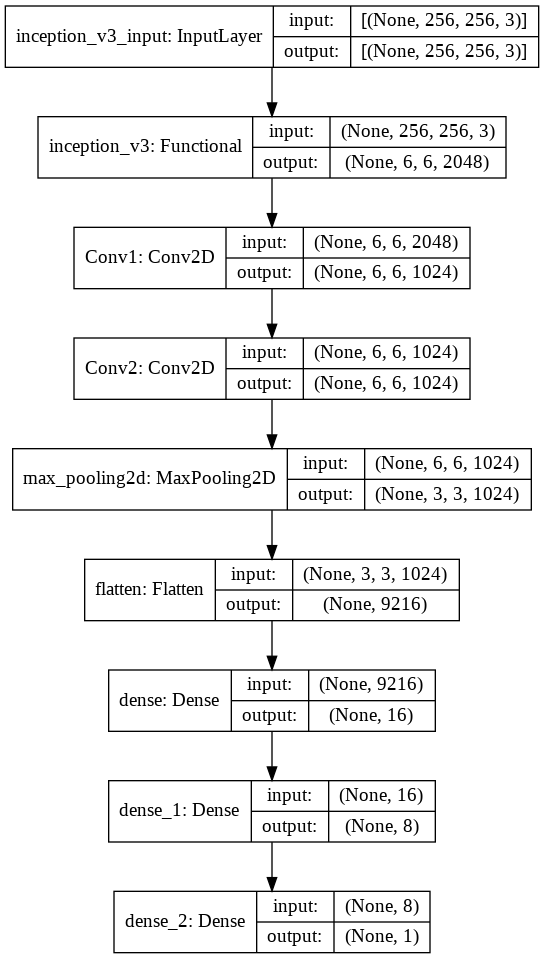

In [ ]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy',tf.keras.metrics.AUC(),threshold])
tf.keras.utils.plot_model(model,show_shapes=True)

In [ ]:
!rm -rf '/content/logs'

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    # tf.keras.callbacks.ModelCheckpoint(filepath='/content/model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='/content/logs'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=5,min_lr=0.001)
]
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_cv, y_cv), steps_per_epoch=100, verbose=2,callbacks=[callbacks])

In [ ]:
%tensorboard --logdir /content/logs

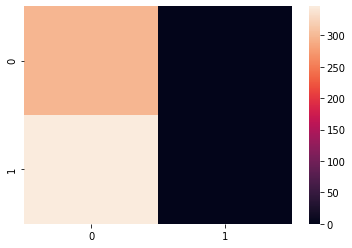

#####################
accuracy: 0.46273291925465837
#####################
#####################
auc_score: 0.5
#####################
#####################
classsifciation Report               precision    recall  f1-score   support

           0       0.46      1.00      0.63       298
           1       0.00      0.00      0.00       346

    accuracy                           0.46       644
   macro avg       0.23      0.50      0.32       644
weighted avg       0.21      0.46      0.29       644

#####################


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
pred = predict(X_test,model,th = 0.986)
result = metrics(y_test,pred)

## Transfer learning with ResNet50

**ResNet50**

In [ ]:
from tensorflow.keras.applications import ResNet50
resnet_model = ResNet50(input_shape=(256, 256,3), include_top=False, weights="imagenet")

94773248/94765736 [==============================] - 0s 0us/step


In [ ]:
for layer in resnet_model.layers:
    layer.trainable = False

In [ ]:
tf.keras.backend.clear_session()
model = Sequential()

model.add(resnet_model)

#Conv Layer
model.add(Conv2D(filters=1024,kernel_size=kernel_size_,padding='same',data_format='channels_last',
              activation='relu',name='Conv1',kernel_regularizer=tf.keras.regularizers.l2(0.001)))
#Conv Layer
model.add(Conv2D(filters=1024,kernel_size=kernel_size_,padding='same',data_format='channels_last',
              activation='relu',name='Conv2'))

#maxpool layer
# model.add(MaxPool2D(pool_size = (2,2), strides = (2,2), padding = 'same', data_format= 'channels_last'))

#flatten layer
model.add(Flatten(data_format = 'channels_last'))

#output layer
model.add(Dense(units = 16, activation = 'relu', kernel_initializer=tf.keras.initializers.he_normal(seed=3)))
model.add(Dense(units = 8, activation = 'relu', kernel_initializer=tf.keras.initializers.he_normal(seed=3)))
model.add(Dense(units = 1, activation = 'sigmoid', kernel_initializer=tf.keras.initializers.he_normal(seed=3)))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 8, 8, 2048)        23587712  
_________________________________________________________________
Conv1 (Conv2D)               (None, 8, 8, 1024)        134218752 
_________________________________________________________________
Conv2 (Conv2D)               (None, 8, 8, 1024)        67109888  
_________________________________________________________________
flatten (Flatten)            (None, 65536)             0         
_________________________________________________________________
dense (Dense)                (None, 16)                1048592   
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9

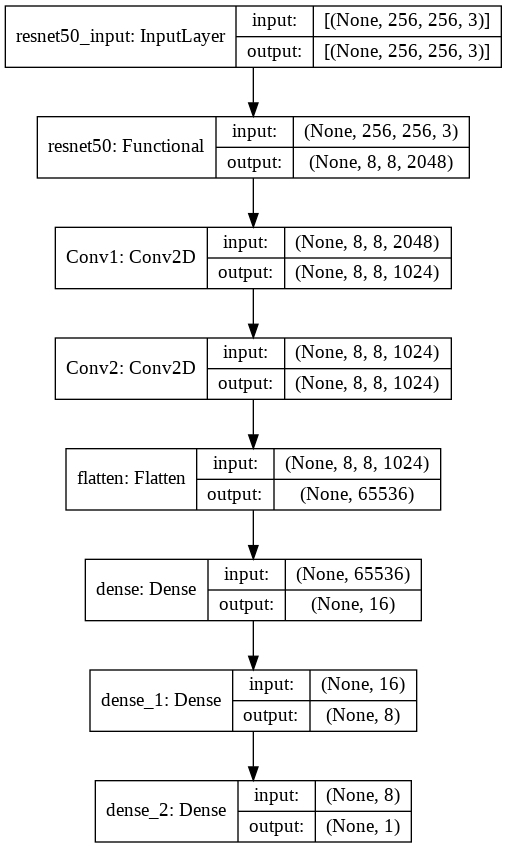

In [ ]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy',tf.keras.metrics.AUC()])
tf.keras.utils.plot_model(model,show_shapes=True)

In [ ]:
!rm -rf '/content/logs'

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    # tf.keras.callbacks.ModelCheckpoint(filepath='/content/model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='/content/logs'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=5,min_lr=0.001)
]
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_cv, y_cv), steps_per_epoch=100, verbose=2,callbacks=[callbacks])

In [ ]:
%tensorboard --logdir /content/logs

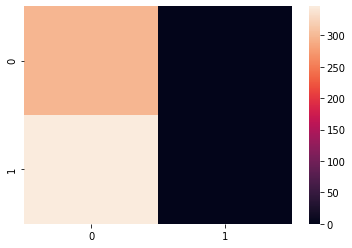

#####################
accuracy: 0.46273291925465837
#####################
#####################
auc_score: 0.5
#####################
#####################
classsifciation Report               precision    recall  f1-score   support

           0       0.46      1.00      0.63       298
           1       0.00      0.00      0.00       346

    accuracy                           0.46       644
   macro avg       0.23      0.50      0.32       644
weighted avg       0.21      0.46      0.29       644

#####################


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
pred = predict(X_test,model,th = 0.996)
result = metrics(y_test,pred)

## Transfer Learning Efficient Net

**Efficient Net**

In [ ]:
# !pip install -U efficientnet

In [ ]:
import efficientnet.keras as efn

In [ ]:
effnet_model = efn.EfficientNetB0(input_shape = (256, 256, 3), include_top = False, weights = 'imagenet')

16809984/16804768 [==============================] - 0s 0us/step


In [ ]:
for layer in effnet_model.layers:
    layer.trainable = False

In [ ]:
tf.keras.backend.clear_session()
model = Sequential()

model.add(effnet_model)

#Conv Layer
model.add(Conv2D(filters=1024,kernel_size=kernel_size_,padding='same',data_format='channels_last',
              activation='relu',name='Conv1',kernel_regularizer=tf.keras.regularizers.l2(0.001)))
#Conv Layer
model.add(Conv2D(filters=1024,kernel_size=kernel_size_,padding='same',data_format='channels_last',
              activation='relu',name='Conv2'))

#maxpool layer
model.add(MaxPool2D(pool_size = (2,2), strides = (2,2), padding = 'same', data_format= 'channels_last'))

#flatten layer
model.add(Flatten(data_format = 'channels_last'))

#output layer
model.add(Dense(units = 16, activation = 'relu', kernel_initializer=tf.keras.initializers.he_normal(seed=3)))
model.add(Dense(units = 8, activation = 'relu', kernel_initializer=tf.keras.initializers.he_normal(seed=3)))
model.add(Dense(units = 1, activation = 'sigmoid', kernel_initializer=tf.keras.initializers.he_normal(seed=3)))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Functional) (None, 8, 8, 1280)        4049564   
_________________________________________________________________
Conv1 (Conv2D)               (None, 8, 8, 1024)        83887104  
_________________________________________________________________
Conv2 (Conv2D)               (None, 8, 8, 1024)        67109888  
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 4, 1024)        0         
_________________________________________________________________
flatten (Flatten)            (None, 16384)             0         
_________________________________________________________________
dense (Dense)                (None, 16)                262160    
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 1

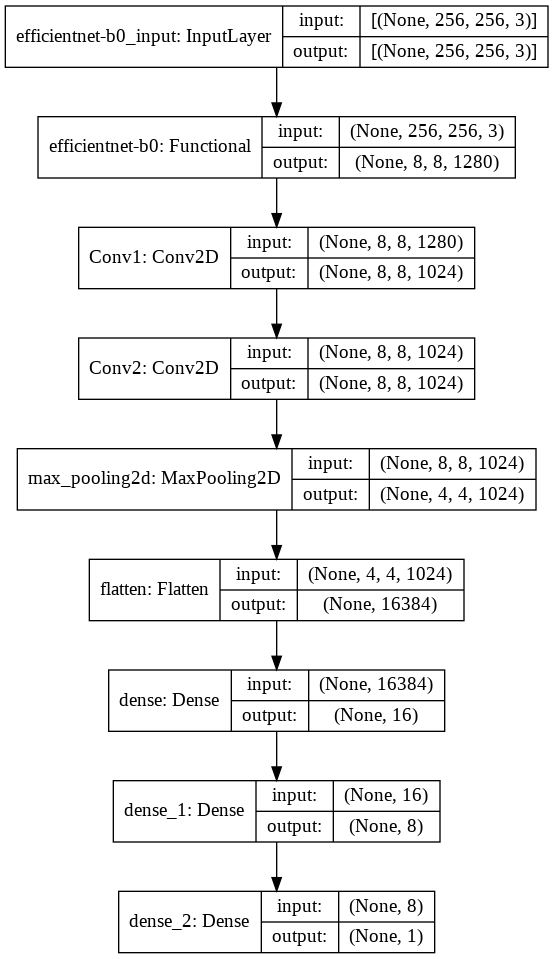

In [ ]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy',tf.keras.metrics.AUC(),threshold])
tf.keras.utils.plot_model(model,show_shapes=True)

In [ ]:
!rm -rf '/content/logs'

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    # tf.keras.callbacks.ModelCheckpoint(filepath='/content/model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='/content/logs'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=5,min_lr=0.001)
]
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_cv, y_cv), steps_per_epoch=100, verbose=2,callbacks=[callbacks])

In [ ]:
%tensorboard --logdir /content/logs

In [ ]:
pred = predict(X_test,model,th = 0.996)
result = metrics(y_test,pred)

## Model Comparison

In [ ]:
from prettytable import PrettyTable
x = PrettyTable()

In [ ]:
x.field_names = ["Model", "Accuracy", "AUC"]
x.add_row(["Simple CNN", 0.462, 0.5])
x.add_row(["Transfer Learning VGG16", 0.462, 0.5])
x.add_row(["Transfer Learning InceptionV3",0.462,0.5])
x.add_row(["Transfer Learning ResNet50",0.495,0.500])
x.add_row(["Transfer Learning EfficientNet",0.495,0.500])

In [ ]:
print(x)

+--------------------------------+----------+--------+
|             Model              | Accuracy |  AUC   |
+--------------------------------+----------+--------+
|           Simple CNN           |  0.4951  |  0.5   |
|    Transfer Learning VGG16     |  0.5883  | 0.6079 |
| Transfer Learning InceptionV3  |  0.4951  |  0.5   |
|   Transfer Learning ResNet50   |  0.495   |  0.5   |
| Transfer Learning EfficientNet |  0.495   |  0.5   |
+--------------------------------+----------+--------+
